In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
%matplotlib inline

In [4]:
above = '../../../'
data = pd.read_pickle(above + 'post_eda.pkl') #('merged-sales-val-macro-dem-crime.pkl')
#data = data[data['s_total_units'] < 4]
#data = data.drop('s_bbl',1)

In [5]:
categorical_features_mask = data.dtypes == 'object'
categorical_features = data.columns[categorical_features_mask]
print(categorical_features)

Index([], dtype='object')


In [6]:
numeric_features = pd.concat([data[data.columns[data.dtypes == 'int64']], data[data.columns[data.dtypes == 'float64']]], axis=1).columns
print(numeric_features)

Index(['s_borough', 's_sale_price', 'v_fullval', 's_sale_month', 's_sale_year',
       'd_pop_25_years_and_over', 'd_total_housing_units',
       'd_owner_occupied_units', 'd_median_housing_price',
       'd_total_households',
       ...
       'd_households_from_50000_to_74999_pct',
       'd_households_from_75000_to_99999',
       'd_households_from_75000_to_99999_pct',
       'd_households_from_100000_to_149999',
       'd_households_from_100000_to_149999_pct',
       'd_households_from_150000_to_199999',
       'd_households_from_150000_to_199999_pct', 'd_households_200000_or_more',
       'd_households_200000_or_more_pct', 'imputed_land_area'],
      dtype='object', length=124)


In [7]:
cat = len(categorical_features)
num = len(numeric_features)
print('Total Features: ', cat, 'categorical', '+',
      num, 'numerical', '=', cat+num, 'features')

Total Features:  0 categorical + 124 numerical = 124 features


In [8]:
corr_matrix = data.corr() #data.loc[:, numeric_col_mask].corr()

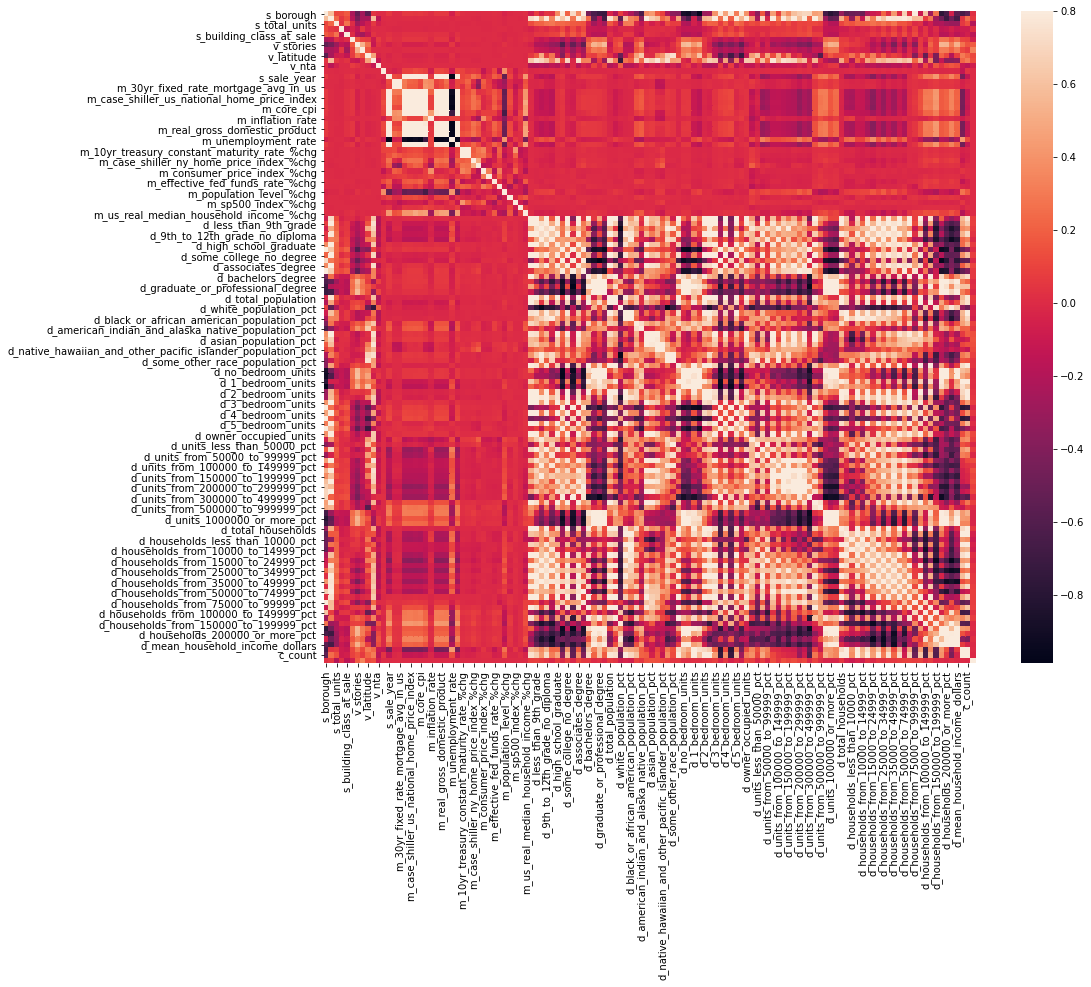

In [9]:
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(corr_matrix, vmax=.8, square=True)
fig.savefig('corr_heatmap_125.png')

In [10]:
corr_with_target = corr_matrix['s_sale_price']
print(np.abs(corr_with_target).sort_values(ascending=False).head(20))
print()
print(np.abs(corr_with_target).sort_values(ascending=False).tail(10))

s_sale_price                             1.000000
d_units_1000000_or_more_pct              0.278281
d_households_200000_or_more              0.277483
d_median_housing_price                   0.275508
d_graduate_or_professional_degree_pct    0.274319
d_households_200000_or_more_pct          0.269880
d_high_school_graduate_pct               0.267705
d_bachelors_degree_pct                   0.266063
d_no_bedroom_units                       0.265648
d_no_bedroom_units_pct                   0.262121
d_mean_household_income_dollars          0.260234
d_associates_degree_pct                  0.255706
d_some_college_no_degree_pct             0.254696
d_units_1000000_or_more                  0.247795
d_graduate_or_professional_degree        0.245249
d_units_from_300000_to_499999_pct        0.243986
d_units_from_200000_to_299999_pct        0.235993
d_households_from_50000_to_74999_pct     0.227639
s_borough                                0.226833
d_households_from_35000_to_49999_pct     0.226425


In [11]:
k = 10
top_k_corr_features = np.abs(corr_with_target).sort_values(ascending=False).head(k).index.tolist()
print(corr_with_target[top_k_corr_features])

s_sale_price                             1.000000
d_units_1000000_or_more_pct              0.278281
d_households_200000_or_more              0.277483
d_median_housing_price                   0.275508
d_graduate_or_professional_degree_pct    0.274319
d_households_200000_or_more_pct          0.269880
d_high_school_graduate_pct              -0.267705
d_bachelors_degree_pct                   0.266063
d_no_bedroom_units                       0.265648
d_no_bedroom_units_pct                   0.262121
Name: s_sale_price, dtype: float64


In [12]:
data_narrowed = data[top_k_corr_features]

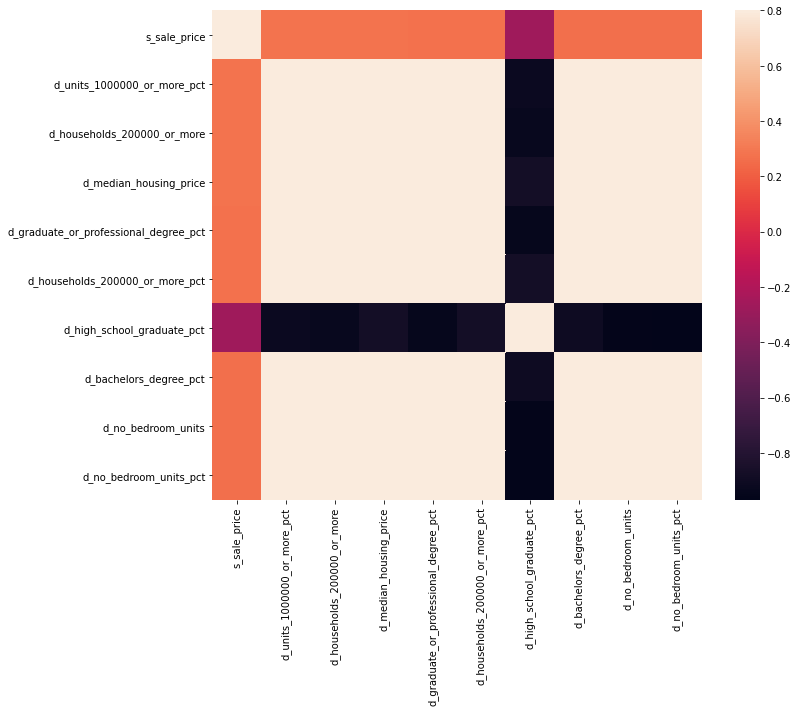

In [13]:
top_k_corr_matrix = data[top_k_corr_features].corr()
fig, ax = plt.subplots(figsize=(12, 9))
corr_heatmap_10 = sns.heatmap(top_k_corr_matrix, vmax=.8, square=True)
fig.savefig('corr_heatmap_10.png')

In [14]:
downsample_samples = random.sample(data_narrowed.index.tolist(), 500)
downsampled_narrow_data = data_narrowed.loc[downsample_samples]

Forward Selection

In [15]:
from sklearn.model_selection import KFold
from sklearn import linear_model


def runXVal_LogLoss(cv, X_sub, Y_tr):
    '''
    Runs LR cross validation with no regularization, returns mean and standard error of mean
    '''
    ll = []; 
    for train_index, test_index in cv.split(X_sub):
        X_tr_f = X_sub.iloc[train_index]
        X_va_f = X_sub.iloc[test_index]
        Y_tr_f = Y_tr.iloc[train_index]
        Y_va_f = Y_tr.iloc[test_index]

        lr = linear_model.LogisticRegression()
        lr.fit(X_tr_f, Y_tr_f)
        P = lr.predict_proba(X_va_f)[:,1]
        
        ll.append(-1*(((Y_va_f==1)*np.log(P)+(Y_va_f==0)*np.log(1-P)).mean()))

    return [np.array(ll).mean(), np.array(ll).std()/np.sqrt(len(ll))]
        
def LrForward_LogLoss(X_tr, Y_tr, cv):
    '''
    Runs cross-validated stepwise selection
    Does not pick the best features, but returns data
    Returns a dictionary that shows at each k: [feature set], x-validated mean, x-validated var 
    For each loop, chooses the feature with best mean+1stderr
    '''
    results = {}
    curr_best = set([])
    cand_list = set(X_tr.columns.values)
    k = 1
    
    while (len(cand_list)>0):
        best_mu = 10**10; best_serr = 10**10; 
        for f in cand_list:
            use_x = list(curr_best)+[f]
            mu, serr = runXVal_LogLoss(cv, X_tr[use_x], Y_tr)
            if ((mu + serr) < (best_mu + best_serr)):
                best_mu = mu
                best_serr = serr
                best_f = f
        curr_best.add(best_f) #Add the best feature to the curr_best_set
        cand_list = cand_list.difference(curr_best) #Remove the best feature from the candidate set
        results[k] = [list(curr_best), best_mu, best_serr]
        k+=1
        
    return results
            

In [16]:
#Run the forward selection
#data_subset = data_narrowed.iloc[0:2000,]
label = 's_sale_price'
cv = KFold(n_splits=10)
r = LrForward_LogLoss(downsampled_narrow_data.drop(label,1), downsampled_narrow_data[label], cv)

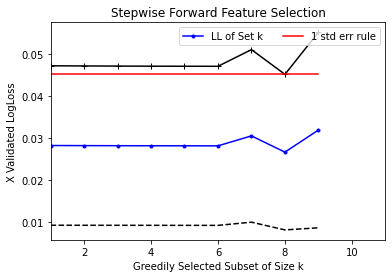

In [17]:
#Now plot the incremental results
ks = []; mus = []; serrs = [];
for i in range(len(r.keys())):
    ks.append(i+1)
    mus.append(r[i+1][1])
    serrs.append(r[i+1][2])

    
best_1serr = min(np.array(mus) + np.array(serrs))
plt.clf()
plt.plot(ks, mus, 'b.-', label = 'LL of Set k')
plt.plot(ks, np.array(mus) + np.array(serrs), 'k+-')
plt.plot(ks, np.array(mus) - np.array(serrs), 'k--')
plt.plot(ks, np.ones(len(ks))*best_1serr, 'r', label ='1 std err rule')

plt.xlim([1,11])

plt.title('Stepwise Forward Feature Selection')
plt.xlabel('Greedily Selected Subset of Size k')
plt.ylabel('X Validated LogLoss')
    
plt.legend(loc=1, ncol=2)
plt.show()

SVD

In [18]:
data_pca = data.copy()
data_pca.drop(["s_sale_date"], axis =1, inplace=True)
# normalize data
data_pca_norm = (data_pca - data_pca.mean()) / data_pca.std()

In [19]:
data_pca

,s_borough,s_zipcode,s_total_units,s_year_built,s_building_class_at_sale,s_sale_price,v_stories,v_fullval,v_latitude,v_longitude,...,d_households_from_100000_to_149999_pct,d_households_from_150000_to_199999,d_households_from_150000_to_199999_pct,d_households_200000_or_more,d_households_200000_or_more_pct,d_median_household_income_dollars,d_mean_household_income_dollars,a_count,c_count,imputed_land_area
0,2,10458.0,1.0,1910.0,10.0,329000,2.0,365000,40.856635,-73.892647,...,0.081,10744.174,0.023,6072.794,0.013,33101,48178,8448,8671,1667.0
1,2,10457.0,2.0,1899.0,29.0,115000,2.0,433000,40.852259,-73.896728,...,0.081,10744.174,0.023,6072.794,0.013,33101,48178,8448,8671,2275.0
2,2,10458.0,3.0,1901.0,32.0,167500,3.0,137000,40.854837,-73.892216,...,0.081,10744.174,0.023,6072.794,0.013,33101,48178,8448,8671,2011.0
3,2,10457.0,3.0,1931.0,3.0,292500,2.0,398000,40.848517,-73.896224,...,0.081,10744.174,0.023,6072.794,0.013,33101,48178,8448,8671,1493.0
4,2,10469.0,1.0,1930.0,9.0,255000,2.0,333000,40.874588,-73.850192,...,0.081,10744.174,0.023,6072.794,0.013,33101,48178,8448,8671,1900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315064,5,10309.0,2.0,2005.0,29.0,890000,2.0,793000,40.533587,-74.204538,...,0.193,20595.243,0.123,18083.628,0.108,82166,101953,936,1866,4000.0
315065,5,10309.0,2.0,2009.0,29.0,1030000,2.0,959000,40.536844,-74.206480,...,0.193,20595.243,0.123,18083.628,0.108,82166,101953,936,1866,4300.0
315066,5,10309.0,2.0,1987.0,12.0,615000,2.0,504000,40.536283,-74.208889,...,0.193,20595.243,0.123,18083.628,0.108,82166,101953,936,1866,2500.0
315067,5,10309.0,2.0,2001.0,29.0,780000,2.0,839000,40.539312,-74.216695,...,0.193,20595.243,0.123,18083.628,0.108,82166,101953,936,1866,5260.0


In [20]:
import numpy as np
from sklearn.decomposition import PCA

# pca = PCA(n_components=50)
# pca.fit(data_scaled)
# PCA
pca = PCA(n_components=50)
#pca.fit_transform(data_pca_norm)

In [21]:
pca.components_

AttributeError: 'PCA' object has no attribute 'components_'

In [ ]:
data_pca.iloc[:, pca.components_[0].argmax()]

In [ ]:
pca.fit(data_pca_norm)
#Get the components from transforming the original data.
scores = pca.transform(data_pca_norm)
# Reconstruct from the 50 dimensional scores 
reconstruct = pca.inverse_transform(scores)
#The residual is the amount not explained by the first 50 components
residual=data_pca_norm-reconstruct

In [ ]:
residual

In [ ]:
# Dump components relations with features:
print(pd.DataFrame(pca.components_,columns=data_scaled.columns,index = ['PC-1','PC-2']))

In [ ]:
n_components = 50
pd.DataFrame(pca.transform(data_pca_norm), columns=['PCA%i' % i for i in range(n_components)], index=data_pca_norm.index)

In [ ]:
U, sig, Vt = np.linalg.svd(data_narrowed)

In [ ]:
plt.plot(np.cumsum(sig**2)/np.sum(sig**2))
plt.show()